## Setup Utilities

In [45]:
# Automatically install tdgl from GitHub only if running in Google Colab
if "google.colab" in str(get_ipython()):
    %pip install --quiet git+https://github.com/loganbvh/py-tdgl.git
    !apt install ffmpeg

In [46]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import tempfile

os.environ["OPENBLAS_NUM_THREADS"] = "1"

from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

Optionally, generate and display animations of simulated dynamics.

In [47]:
MAKE_ANIMATIONS = True

We will save the data to a temporary directory that will be removed at the end of the notebook.

In [48]:
tempdir = tempfile.TemporaryDirectory()

Below we can create animations of the time-dependent simulation results. This is a helper function that animates a `tdgl.Solution` object so that it can be embedded in a notebook.

In [49]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

## Superconducting Weak Link

#### Defining the device

In [50]:
length_units = "um"
# Material parameters
xi = 0.5
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 5
total_length = 3.5 * total_width
link_width = total_width / 3
# Outer geometry of the film
right_notch = (
    tdgl.Polygon(points=box(total_width))
    .rotate(45)
    .translate(dx=(np.sqrt(2) * total_width + link_width) / 2)
)
left_notch = right_notch.scale(xfact=-1)
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .difference(right_notch, left_notch)
    .resample(401)
    .buffer(0)
)
# Holes in the film
round_hole = (
    tdgl.Polygon("round_hole", points=circle(link_width / 2))
    .translate(dy=total_length / 5)
)
square_hole = (
    tdgl.Polygon("square_hole", points=box(link_width))
    .rotate(45)
    .translate(dy=-total_length / 5)
)
# Current terminals
source = (
    tdgl.Polygon("source", points=box(1.1 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")
#  Voltage measurement points
probe_points = [(0, total_length / 2.5), (0, -total_length / 2.5)]

In [51]:
device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    holes=[round_hole, square_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

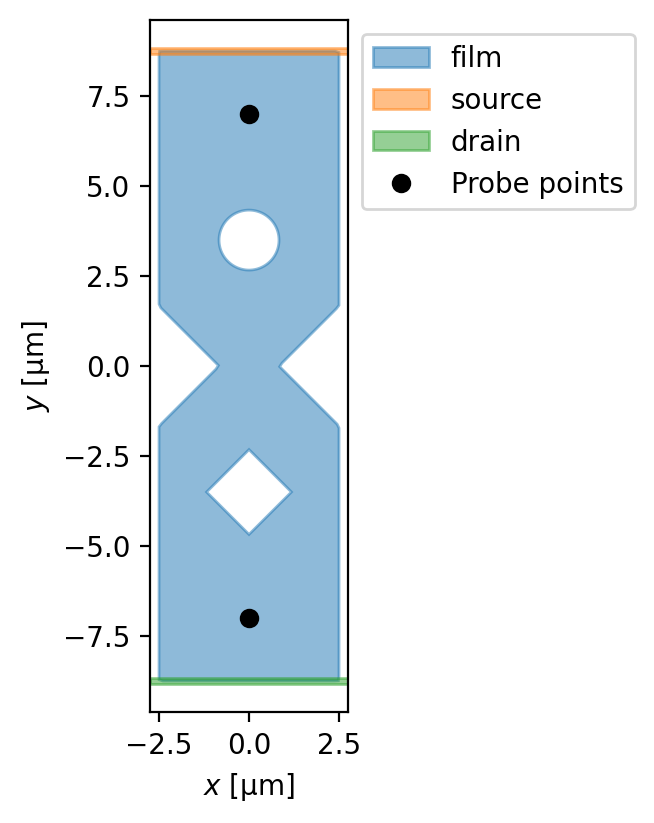

In [52]:
fig, ax = device.draw()

Generate the finite volume mesh by calling `tdgl.Device.make_mesh()`. You can specify a minimum number of mesh vertices (`min_points`) and/or a maximum edge length (`max_edge_length`). Generally, the edges in the mesh should be small compared to the coherence length $\xi$.

In [53]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)

Constructing Voronoi polygons: 100%|██████████| 4712/4712 [00:02<00:00, 1791.61it/s]


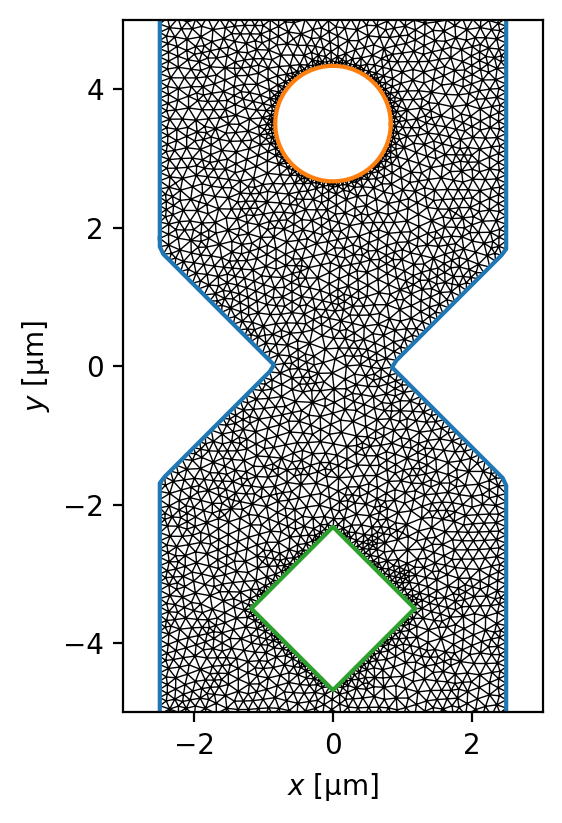

In [54]:
fig, ax = device.plot(mesh=True, legend=False)
_ = ax.set_ylim(-5, 5)

In [55]:
device.mesh_stats()

num_sites,4712
num_elements,8830
min_edge_length,3.438e-02
max_edge_length,2.449e-01
mean_edge_length,1.399e-01
min_area,6.684e-04
max_area,3.617e-02
mean_area,1.634e-02
coherence_length,5.000e-01
length_units,um


#### Simulating with zero applied field

Below we simulate our device with zero applied magnetic field and a constant bias current flowing from the source terminal (top) to the drain terminal (bottom).

The behavior of the TDGL solver is specified by creating an instance of `tdgl.SolverOptions`. If the `output_file` parameter is not given, the results of the simulation will not be saved, and only the results from the final solve step will be accessible in the resulting `tdgl.Solution`. The save_every parameter determines how often the results are saved to disk, e.g., `save_every = 100` means that the outputs $\psi(\textbf{r},t)$, $\mu(\textbf{r},t)$, $\textbf{K}_s(\textbf{r},t)$, and $\textbf{K}_n(\textbf{r},t)$ will be saved every 100 solve steps. The scalar potential and phase at the two `probe_points` will be saved for every time step, regardless of the value of `save_every`.

Executing a TDGL simulation is accomplished by calling `tdgl.solve()`. `tdgl.solve()` returns a `tdgl.Solution` instance, which can be used to post-process, inspect, and visualize the results of the simulation.

In [56]:
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    skip_time=100,
    solve_time=150,
    output_file=os.path.join(tempdir.name, "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100,
    # gpu=True,
)
# If you do not provide an applied_vector_potential, tdgl defaults to zero applied field.
zero_field_solution = tdgl.solve(
    device,
    options,
    # terminal_currents must satisfy current conservation, i.e.,
    # sum(terminal_currents.values()) == 0.
    terminal_currents=dict(source=12, drain=-12),
)

Simulating: 100%|█████████▉| 150/150 [00:45<00:00,  3.30tau/s ]


Here we plot the sheet current density $\textbf{K}(\textbf{r})$ at the final time step, and measure the total current flowing from top to bottom. The dashed orange line indicates the curve through which the total current is calculated.

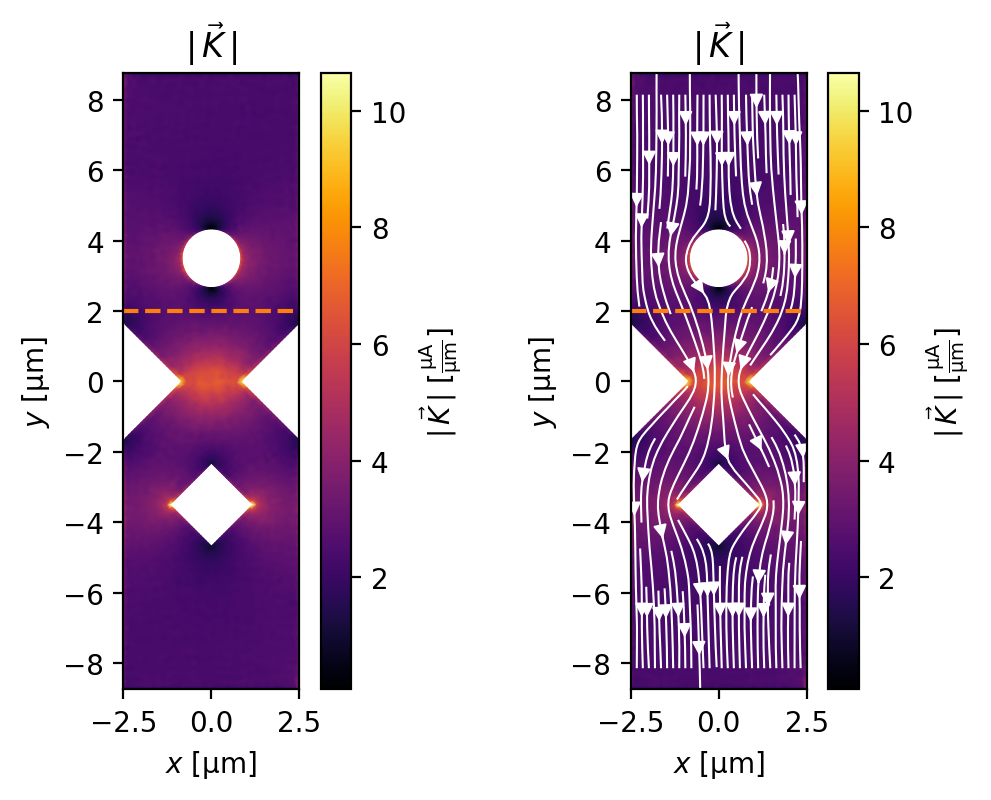

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False)
_ = zero_field_solution.plot_currents(ax=axes[1])
# Define the coordinates at which to evaluate the sheet current density
x = np.linspace(-total_width / 2, total_width / 2, 401)
y = 2 * np.ones_like(x)
cross_section = np.array([x, y]).T
for ax in axes:
    _ = ax.plot(x, y, "C1--")

In [58]:
current = zero_field_solution.current_through_path(cross_section)
print(f"Measured current: {current:.3f~P}")

Measured current: 11.948 µA


When there is zero applied magnetic field and an applied bias current $I_\text{bias}$ that exceeds the critial current of the weak link, the weak link acts as a site for vortex or phase slip nucleation driven by the bias current.

Due to the symmetry of the device and the absence of an applied field, vortices are formed in vortex-antivortex (V-aV) pairs: a vortex is nucleated on the right side of the link and an antivortex is nucleated on the left side of the link. The vortex and antivortex are pushed together by the attractive force between the two and by the Lorentz force from the bias current, so they each move towards the center of the link and eventually annihilate one another. The creation and annihilation of a single V-aV pair in the weak link causes the phase between the top and bottom halves of the device to advance by $2\pi$, and causes a spike in the voltage between the top and bottom halves.

In the figure below, a vortex-antivortex pair is clearly visible in the weak link.

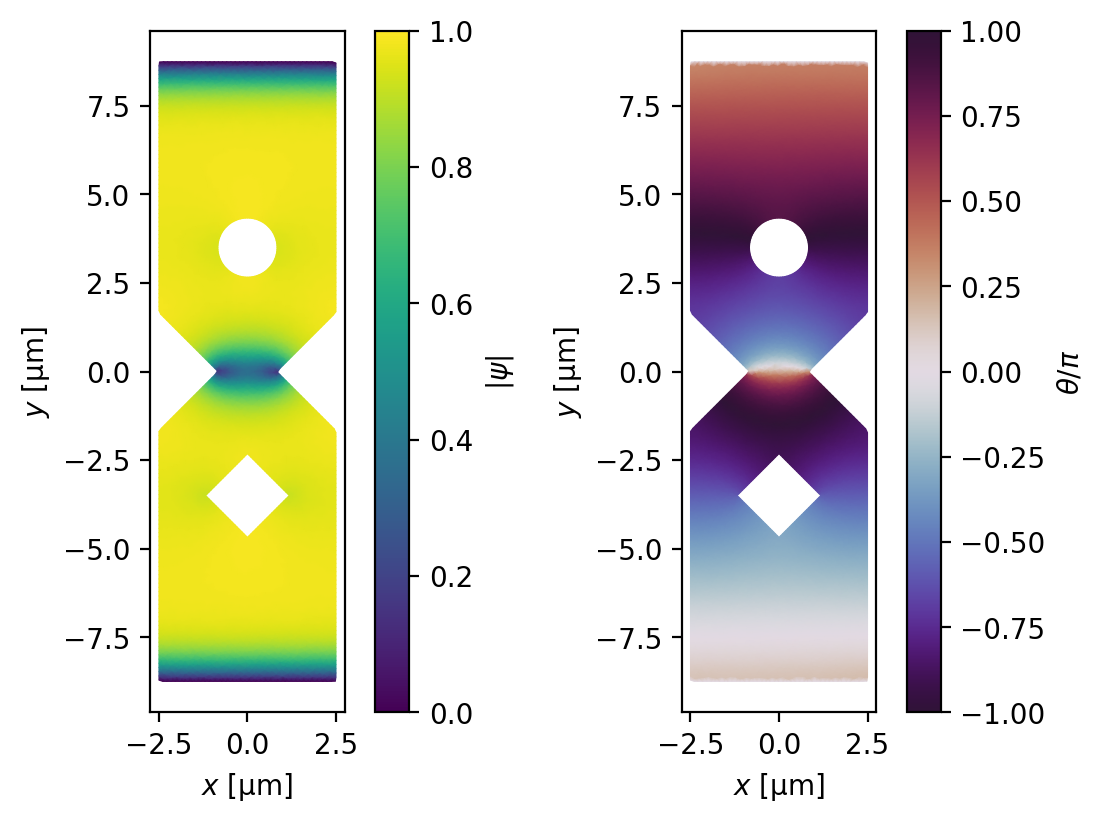

In [59]:
# Plot a snapshot of the order parameter in the middle of a phase slip
t0 = 112
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(t0)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(5.5, 4))

Below we plot the dynamics of the voltage and phase between the top and bottom halves of the device. The dashed horizontal line indicates the time-averaged voltage and the vertical gray line corresponds to the snapshot above. `tdgl.Solution.dynamics` is a container for the voltage and phase difference between the two `probe_points`, which are measured at each time step.

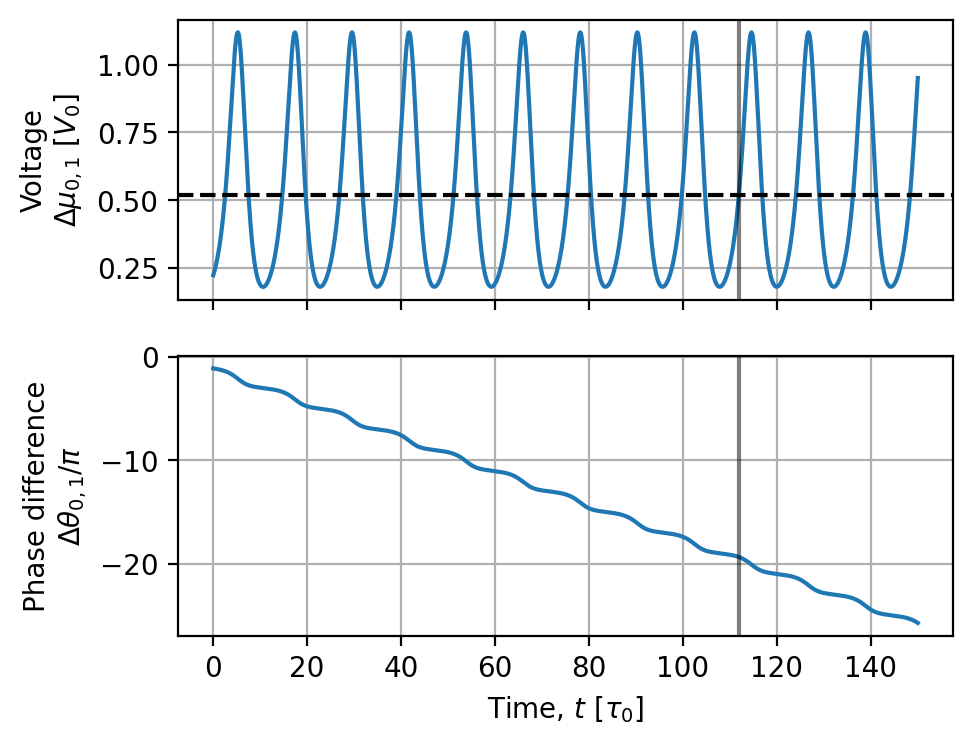

In [60]:
fig, axes = zero_field_solution.dynamics.plot()
for ax in axes:
    ax.axvline(t0, color="k", alpha=0.5)

If we zoom in on a short slice of time, we can see that each voltage spike is associated with a $2\pi$ phase slip:

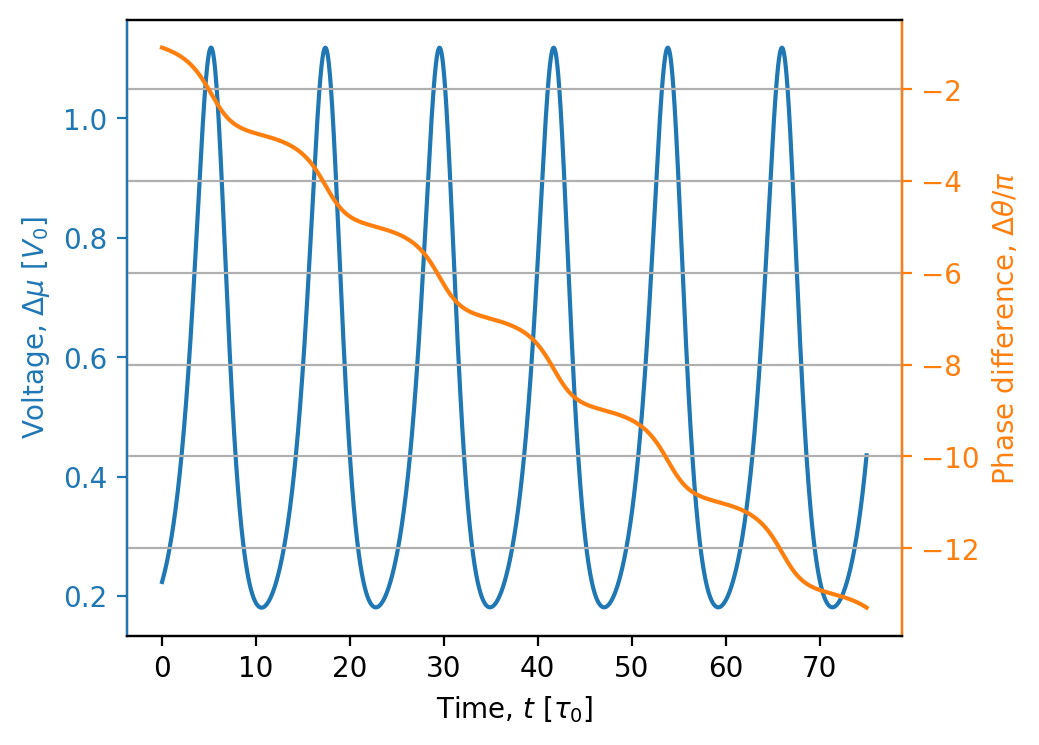

In [61]:
dynamics = zero_field_solution.dynamics
indices = dynamics.time_slice(tmax=75)

fig, ax = plt.subplots()
# Plot the voltage on the left y axis
ax.plot(dynamics.time[indices], dynamics.voltage()[indices], "C0-")
ax.tick_params(axis="y", color="C0", labelcolor="C0")
ax.set_ylabel("Voltage, $\\Delta\\mu$ [$V_0$]", color="C0")
ax.set_xlabel("Time, $t$ [$\\tau_0$]")

# Plot the phase difference on the right y axis
bx = ax.twinx()
unwrapped_phase = np.unwrap(dynamics.phase_difference()[indices])
bx.plot(dynamics.time[indices], unwrapped_phase / np.pi, "C1")
bx.grid(axis="both")
bx.spines["right"].set_color("C1")
bx.spines["left"].set_color("C0")
bx.tick_params(axis="y", color="C1", labelcolor="C1")
_ = bx.set_ylabel("Phase difference, $\\Delta\\theta/\\pi$", color="C1")

We can visualize the simulated dynamics as a function of position in the device by creating an animation. Note that because `tdgl` uses an adaptive time step by default, each frame of the animation does not correspond to the same amount of time. If you would like to create an animation with a constant frame rate, you should set `tdgl.SolverOptions.adaptive = False` to force a constant time step.

In [66]:
if MAKE_ANIMATIONS:
    zero_field_video = make_video_from_solution(
        zero_field_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
    display(zero_field_video)

#### Simulating vortex dynamics with zero bias current

When there is zero bias current and an applied out-of-plane magnetic field $\mu_0H_z$ that exceeds the lower critical field of the device, vortices enter the film and either become trapped in one of the holes or remain in the film. The final position of the vortices is determined by the applied field and the repulsive vortex-vortex interaction.

In [68]:
options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join(tempdir.name, "weak-link-zero-current.h5"),
    field_units = "mT",
    current_units="uA",
)

RAMP_FIELD = True

if RAMP_FIELD:
    from tdgl.sources import LinearRamp, ConstantField

    # Ramp the applied field from 0 to 0.4 mT between t=0 and t=100, then hold it at 0.4 mT.
    applied_vector_potential = (
        LinearRamp(tmin=0, tmax=100)
        * ConstantField(0.4, field_units=options.field_units, length_units=device.length_units)
    )
else:
    # If applied_vector_potential is given as a single number,
    # it is interpreted to mean the vector potential associated with a
    # uniform out-of-plane magnetic field with the specified strength.
    # This is simply shorthand for
    # ConstantField(0.4, field_units=options.field_units, length_units=device.length_units).
    applied_vector_potential = 0.4

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
)

Simulating: 100%|█████████▉| 200/200 [02:14<00:00,  1.48tau/s ]


In [70]:
options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join(tempdir.name, "weak-link.h5"),
    field_units="mT",
    current_units="uA",
)

field_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=0.4,
    terminal_currents=dict(source=12, drain=-12),
    # The seed solution will be used as the initial state of the film.
    seed_solution=zero_current_solution,
)

Output file already exists. Renaming to C:\Users\jsche\AppData\Local\Temp\tmpmvxtj845\weak-link-1.h5.
Simulating: 100%|█████████▉| 200/200 [01:06<00:00,  3.01tau/s ]
